# Running an MSTIS simulation

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Creating initial conditions for a path sampling simulation
* Setting up and running path sampling simulations
* Visualizing trajectories while the path sampling is running

In [1]:
from __future__ import print_function
%matplotlib inline
import openpathsampling as paths
import numpy as np

## Setting up the simulation

### Loading from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [2]:
old_store = paths.Storage("mstis_bootstrap.nc", mode='r')

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [3]:
print("PathMovers: "+ str(len(old_store.pathmovers)))
print("Samples: " +  str(len(old_store.samples)))
print("Ensembles: " + str(len(old_store.ensembles)))
print("SampleSets: " + str(len(old_store.samplesets)))
print("Snapshots: " + str(len(old_store.snapshots)))
print("Networks: " + str(len(old_store.networks)))

PathMovers: 0
Samples: 10
Ensembles: 120
SampleSets: 1
Snapshots: 732
Networks: 0


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create.

In [4]:
template = old_store.snapshots[0]

Named objects can be found in storage by using their name as a dictionary key. This allows us to load our old engine, collective variables, and states.

In [5]:
engine = old_store.engines['toy_engine']

In [6]:
opA = old_store.cvs['opA']
opB = old_store.cvs['opB']
opC = old_store.cvs['opC']

In [7]:
stateA = old_store.volumes['A']
stateB = old_store.volumes['B']
stateC = old_store.volumes['C']

### Creating new interface set, network, and move scheme

In [8]:
# we could also load the interfaces, but it is just as easy:
interfacesA = paths.VolumeInterfaceSet(opA, 0.0,[0.2, 0.3, 0.4])
interfacesB = paths.VolumeInterfaceSet(opB, 0.0,[0.2, 0.3, 0.4])
interfacesC = paths.VolumeInterfaceSet(opC, 0.0,[0.2, 0.3, 0.4])

Once again, we have everything we need to build the MSTIS network. Recall that this will create all the ensembles we need for the simulation. However, even though the ensembles are semantically the same, these are not the same objects. We'll need to deal with that later.

In [9]:
ms_outers = paths.MSOuterTISInterface.from_lambdas(
    {ifaces: 0.5 
     for ifaces in [interfacesA, interfacesB, interfacesC]}
)
mstis = paths.MSTISNetwork(
    [(stateA, interfacesA),
     (stateB, interfacesB),
     (stateC, interfacesC)],
    ms_outers=ms_outers
).named('mstis')

Finally, we'll create the move scheme. For this, we'll use the default TIS move scheme:

In [10]:
scheme = paths.DefaultScheme(mstis, engine=engine).named("scheme")

Now we need to set up real trajectories that we can use for each of these. We can start by loading the stored sampleset.

## Preparing initial conditions

The OPS object called `Sample` is used to associate a trajectory with a replica ID and an ensemble. The trajectory needs to be associated with an ensemble so we know how to get correct statistics from the many ensembles that we might be sampling simultaneously. The trajectory needs to be associated with a replica ID so that replica exchange approaches can be analyzed.

In [11]:
# load the sampleset we have saved before; there is only one in the file
old_sampleset = old_store.samplesets[0]

Because we've created a new network (and therefore new ensembles), we need to associate the previous trajectories with the new ensembles. 

In [12]:
# TODO: show that the ensembles are equivalent, but not the same

In [13]:
init_conds = scheme.initial_conditions_from_trajectories(old_sampleset)

Missing ensembles:
*  [Out A minus]
*  [Out B minus]
*  [Out C minus]
No extra ensembles.


Note that we are missing trajectories that satisfy the minus ensemble. In real simulations, you'll usually have trajectories in each state (used for creating state definitions), and you can feed those trajectories to the `initial_conditions_from_trajectories` method.

However, in this case, we'll need to run dynamics to create such a trajectory. The code below will do that. To learn more about our version of the minus ensemble, see either the brief description in Section 3.2 of [the first OPS paper](https://doi.org/10.1021/acs.jctc.8b00626), or read the detailed description in [the paper where it was developed](https://doi.org/10.1063/1.4890037).

In general, you will not need code like this; it is primarily to ensure that the tests of this notebook also run correctly.

In [14]:
# We need an A -> A path. We'll use shooting moves to ensure that we get one.

def shoot_until_A_to_A(initial_ensemble, desired_ensemble, sample, engine):
    # we only shoot forward because we know the final frame is the problem
    mover = paths.ForwardShootMover(ensemble=initial_ensemble,
                                    selector=paths.UniformSelector(),
                                    engine=engine)
    while not desired_ensemble(sample):
        print("Shooting from:", sample.trajectory)
        change = mover.move_core([sample])
        if desired_ensemble(change.trials[0]):
            sample = change.trials[0]
    
    return sample
    
minus_samples = []
for minus_ensemble in mstis.special_ensembles['minus']:
    # the TIS ensemble allows A->B; desired_ensemble doesn't 
    initial_state = minus_ensemble.state_vol
    tis_ensemble = mstis.from_state[initial_state].ensembles[0]
    desired_ensemble = paths.TISEnsemble(initial_state, initial_state,
                                         tis_ensemble.interface)
    initial_sample = init_conds[tis_ensemble]
    sample_A_to_A = shoot_until_A_to_A(tis_ensemble, desired_ensemble,
                                       initial_sample, engine)

    sample = minus_ensemble.extend_sample_from_trajectories(
        sample_A_to_A,
        engine=engine,
        replica=-len(minus_samples) - 1
    )
    minus_samples.append(sample)

In [16]:
init_conds = scheme.initial_conditions_from_trajectories(minus_samples,
                                                         sample_set=init_conds)

No missing ensembles.
No extra ensembles.


## Equilibration

In molecular dynamics, you need to equilibrate if you don't start with an equilibrated snapshot (e.g., if you start with you system at an energy minimum, your should equilibrate before you start taking statistics). Similarly, if you start with a set of paths which are far from the path ensemble equilibrium, you need to equilibrate. This could either be because your trajectories are not from the real dynamics (generated with metadynamics, high temperature, etc.) or because your trajectories are not representative of the path ensemble (e.g., if you put transition trajectories into all interfaces).

As with MD, running equilibration can be the same process as running the total simulation. However, in path sampling, it doesn't have to be exactly the same: we can equilibrate without replica exchange moves or path reversal moves, for example.

In [13]:
sset = equil_scheme.initial_conditions_from_trajectories(old_sampleset)

No missing ensembles.
No extra ensembles.


In [23]:
equil_scheme.assert_initial_conditions(sset)

In [39]:
equilibration = paths.PathSampling(
    storage=None,
    sample_set=init_conds,
    move_scheme=scheme
)

In [26]:
#! skip
equilibration.run_until_decorrelated()

Working on Monte Carlo cycle number 5
Running for 1 second -  0.27 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 5 Monte Carlo cycles.


In [27]:
sset = equilibration.sample_set

## Production

### Setting up special ensembles

Whichever way we initially set up the `SampleSet`, at this point it only contains samples for the main sampling trajectories of each transition. Now we need to put trajectories into various auxiliary ensembles.

#### Multiple state outer ensemble

The multiple state outer ensemble is, in fact, sampled during the bootstrapping. However, it is actually sampled once for every state that shares it. It is very easy to find a trajectory that satisfies the ensemble and to load add that sample to our sampleset.

In [19]:
for outer_ens in mstis.special_ensembles['ms_outer']:
    # doesn't matter which we take, so we take the first
    traj = next(s.trajectory for s in old_sampleset if outer_ens(s.trajectory)==True)
    samp = paths.Sample(
            replica=None,
            ensemble=outer_ens,
            trajectory=traj
    )
    # now we apply it and correct for the replica ID
    sset.append_as_new_replica(samp)

In [20]:
sset.sanity_check()
assert(len(sset)==10)

#### Minus interface ensemble

The minus interface ensembles do not yet have a trajectory. We will generate them by starting with same-state trajectories (A-to-A, B-to-B, C-to-C) in each interface, and extending into the minus ensemble.

* check whether the traj is A-to-A
* extend

First we need to make sure that the trajectory in the innermost ensemble of each state also ends in that state. This is necessary so that when we extend the trajectory, it can extends into the minus ensemble.

If the trajectory isn't right, we run a shooting move on it until it is.

In [21]:
for transition in mstis.sampling_transitions:
    innermost_ensemble = transition.ensembles[0]
    shooter = None
    if not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        shooter = paths.OneWayShootingMover(ensemble=innermost_ensemble,
                                            selector=paths.UniformSelector(),
                                            engine=engine)
        pseudoscheme = paths.LockedMoveScheme(root_mover=shooter)
        pseudosim = paths.PathSampling(storage=None, 
                                       move_scheme=pseudoscheme, 
                                       sample_set=sset,
                                      )
    while not transition.stateA(sset[innermost_ensemble].trajectory[-1]):
        pseudosim.run(1)
        sset = pseudosim.sample_set

Now that all the innermost ensembles are safe to use for extending into a minus interface, we extend them into a minus interface:

In [22]:
minus_samples = []
for transition in mstis.sampling_transitions:
    minus_samples.append(transition.minus_ensemble.extend_sample_from_trajectories(
        sset[transition.ensembles[0]].trajectory,
        replica=-len(minus_samples)-1,
        engine=engine
    ))
sset = sset.apply_samples(minus_samples)

In [23]:
sset.sanity_check()
assert(len(sset)==13)

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [28]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("../resources/logging.conf", disable_existing_loggers=False)

In [29]:
storage = paths.storage.Storage("mstis.nc", "w")

In [30]:
storage.save(template)

(store.snapshots[BaseSnapshot] : 2 object(s),
 2,
 187105971573306519336015195686574257893L)

In [ ]:
[cv.with_diskcache() for cv in old_store.cvs]

In [ ]:
mstis_calc = paths.PathSampling(
    storage=storage,
    sample_set=sset,
    move_scheme=paths.DefaultScheme(mstis, engine=engine)
)
mstis_calc.save_frequency = 50

The next block sets up a live visualization. This is optional, and only recommended if you're using OPS interactively (which would only be for very small systems). Some of the same tools can be used to play back the behavior after the fact if you want to see the behavior for more complicated systems. You can create a background (here we use the PES contours), and the visualization will plot the trajectories.

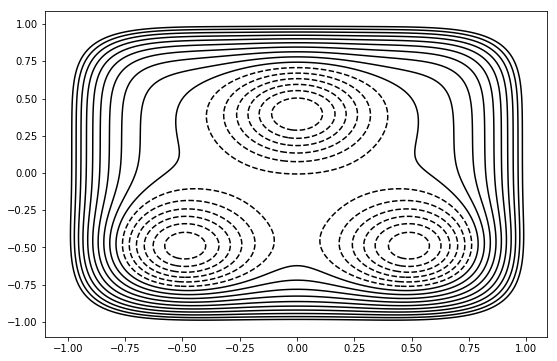

In [34]:
#! skip
# skip this during testing, but leave it for demo purposes
# we use the %run magic because this isn't in a package
%run ../resources/toy_plot_helpers.py
xval = paths.FunctionCV("xval", lambda snap : snap.xyz[0][0])
yval = paths.FunctionCV("yval", lambda snap : snap.xyz[0][1])
mstis_calc.live_visualizer = paths.StepVisualizer2D(mstis, xval, yval, [-1.0, 1.0], [-1.0, 1.0])
background = ToyPlot()
background.contour_range = np.arange(-1.5, 1.0, 0.1)
background.add_pes(engine.pes)
mstis_calc.live_visualizer.background = background.plot()
mstis_calc.status_update_frequency = 1 # increasing this number speeds things up, but isn't as pretty

Now everything is ready: let's run the simulation!

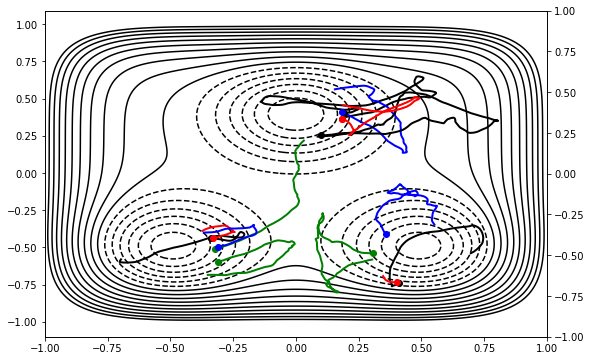

DONE! Completed 100 Monte Carlo cycles.


In [35]:
mstis_calc.run_until(100)

In [36]:
n_steps = int(mstis_calc.move_scheme.n_steps_for_trials(mstis_calc.move_scheme.movers['shooting'][0], 1000))
print(n_steps)

2010


In [37]:
mstis_calc.live_visualizer = None

In [38]:
#! skip
# don't run all those steps in testing!
mstis_calc.run_until(n_steps)

Working on Monte Carlo cycle number 2010
Running for 9 minutes 0 seconds -  0.28 seconds per step
Estimated time remaining: 0 seconds
DONE! Completed 2010 Monte Carlo cycles.
 
*** Profile stats marshalled to file u'run.pstats'. 


In [39]:
storage.close()

## Appendix: Alternate equilibration scheme

The equilibration above uses the same move scheme as the simulation. As remarked, this is not required: you can equilibrate using a different move scheme that samples the same ensembles. For example, the minus move is run much less frequently in the default TIS scheme, which means that it is a long time before the minus ensemble decorrelates. Additionally, moves like path reversal and replica exchange don't do anything to help the initial decorrelation.

Here's an example of how to create a custom move scheme that 